In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline 
import numpy as np
import pandas as pd
from scipy.stats import invgamma
import sqlite3
import time

In [2]:
# Read in the data
def readData(filename, tablename):
    conn = sqlite3.connect(filename)
    c = conn.cursor()
    Dict = []
    sql_command = 'SELECT * FROM ' + tablename
    for row in c.execute(sql_command):
        Dict.append(row)
    data = pd.DataFrame(Dict)
    data.columns = ['index','buy/sell','price','size','ob_level','timestamp']
    data['timestamp'] = pd.to_datetime(data.timestamp)
    bid = data[(data['buy/sell'] == 'buy') & (data['ob_level'] == 1) & ((data['index']-1)%200==0)]
    ask = data[(data['buy/sell'] == 'sell') & (data['ob_level'] == 1) & ((data['index']-11)%200==0)]
    return bid,ask

bid, ask = readData('C:\Users\Superman\Downloads\Harvard Classes\AC 297r\data\data20140108\EX\okcoin.rdb','okcoin_ob')

In [3]:
# Create lags used to run MCMC
def create_lags(data):
    concat_list = [data,data['price'].shift(1)]
    data = pd.concat(concat_list,axis=1).dropna()
    col_names = ["old_index","buy/sell","price","size","ob_level","timestamp","lag1"]
    data.columns = col_names
    newColList = ["diff1"]
    lagList = ["lag1"]
    for i in xrange(len(newColList)):
        data[newColList[i]] = (np.log(data["price"]) - np.log(data[lagList[i]]))
    return data

bid = create_lags(bid)
ask = create_lags(ask)

In [10]:
def graphRawFX():
    fig = plt.figure(figsize=(10,7))
    ax1 = plt.subplot2grid((40,40),(0,0),rowspan=40,colspan=40)

    ax1.plot(range(len(bid)),bid['price'], label="bid")
    #ax1.plot(range(len(ask)),ask['price'], label="ask")
    ax1.legend()
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    ax1_2 = ax1.twinx()

    #ax1_2.fill_between(range(bid.shape[0]),0,(np.array(ask['price'])-np.array(bid['price'])),facecolor='g', alpha=.3)
    
    plt.subplots_adjust(bottom=.23)
    plt.grid(True)
    plt.show()
graphRawFX()

In [4]:
def gibbs(data, N=5000, start = [0,0.01]):
    data = np.array(data)
    m=start[0]
    v=start[1]
    samples=np.zeros((2,N+1))
    samples[0,0]=m
    samples[1,0]=v
    E0 = 1.
    V0 = 1.
    alpha0 = 0.1
    beta0 = 5.
    n = len(data)
    alpha = alpha0 + n/2.
    beta = beta0 + 0.5*sum((data-m)**2)
    
    V = (1./V0 + n/v)**(-1)
    E = V * (E0/V0 * sum(data)/v)
    
    for i in range(1,N,2):
        m=np.random.normal(E, V)
        samples[0,i]=m
        samples[1,i]=v
        V = (1./V0 + n/v)**(-1)
        E = V * (E0/V0 * sum(data)/v)
        
        v=invgamma.rvs(alpha, scale = beta)
        samples[0,i+1]=m
        samples[1,i+1]=v
        
        alpha = alpha0 + n/2.
        beta = beta0 + 0.5*sum((data-m)**2)
        
    return samples[:,:N]

In [5]:
def prediction(thin, burnin, samples):
    m, v = samples[0,:], samples[1,:]
    m = m[0:len(m):thin][burnin:]
    v = v[0:len(v):thin][burnin:]
    
    ypred = np.random.normal(m, v)
    return np.mean(ypred)

In [6]:
def simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,predictionDirB,predictionDirS):
    bank1 = 10**3
    assets1 = 0

    bankTracker1 = [bank1]
    assetTracker1 = [0]

    betSize = .1
    
    for ii in range(30,len(buyPrice)-1):

        buyP1 = buyPrice[ii]
        sellP1 = sellPrice[ii]
        i = ii - 30
        if predictionDirS[i] > 0: # buy
            bank1 = bank1 - betSize*sellP1
            assets1 = assets1 + betSize
        if predictionDirB[i] < 0: # sell
            bank1 = bank1 + betSize*buyP1
            assets1 = assets1 - betSize
            
        bankTracker1.append(bank1)
        assetTracker1.append(assets1)
        
    # close position at end
    if assets1 > 0: # sell
        bank1 = bank1 + assets1*lastBuyPrice
        assets1 = 0
    if assets1 < 0: # buy
        bank1 = bank1 + assets1*lastSellPrice
        assets1 = 0
        
    bankTracker1.append(bank1)
    assetTracker1.append(assets1)

    bankTracker1 = np.array(bankTracker1)
    assetTracker1 = np.array(assetTracker1)
    profit = bankTracker1[-1] - bankTracker1[0]
    
    return profit, bankTracker1, assetTracker1

In [7]:
def mcmcPred(priceList, updateInterval=100, sampleSize=50):
    direction = []
    result = []
    for ii in np.arange(len(priceList)):
        if ii%updateInterval == 0: result = gibbs(priceList[ii:ii+sampleSize], N=1000, start = [0,1])
        if ii%1000 == 0: print "Finish " + str(ii) + "th iteration"
        ypred = prediction(2,1,result)
        if ypred > 0: direction.append(1)
        elif ypred < 0: direction.append(-1)
        else: direction.append(0)
    return direction

In [8]:
def rmse(predPrice, actualPrice):
    return np.sqrt(sum((predPrice - actualPrice)**2))

In [54]:
def compute_accuracy(priceList, direction):
    trueDir = []
    for i in xrange(len(priceList)-1):
        if priceList[i] < priceList[i+1]:
            trueDir.append(1)
        elif priceList[i] > priceList[i+1]:
            trueDir.append(-1)
        else:
            trueDir.append(0)
    counter = 0.
    accurate = 0.
    for i in xrange(len(direction)):
        if direction[i] != 0:
            counter += 1.
            if direction[i] == trueDir[i]:
                accurate += 1.
    return accurate / counter

### First Test Period

In [55]:
import datetime as dt
buyTest = bid[(bid['timestamp'] >= dt.datetime(2014,1,2,23,0,0)) & 
                    (bid['timestamp'] <= dt.datetime(2014,1,4,2,0,0))]
sellTest = ask[(ask['timestamp'] >= dt.datetime(2014,1,2,23,0,0)) & 
                    (ask['timestamp'] <= dt.datetime(2014,1,4,2,0,0))]

In [56]:
directionBuy = mcmcPred(buyTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration
Finish 2000th iteration


In [57]:
directionSell = mcmcPred(sellTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration
Finish 2000th iteration


In [58]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]

In [59]:
p1 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,directionBuy,directionSell)
print p1

(-974.57199999994737, array([  1000.   ,   1000.   ,   1461.501, ..., -14140.372, -14140.572,
           25.428]), array([ 0. ,  0. , -0.1, ...,  3. ,  3. ,  0. ]))


In [60]:
print "Buy Accuracy: ", compute_accuracy(priceList, directionBuy)
print "Sell Accuracy: ", compute_accuracy(priceList, directionSell)

Buy Accuracy:  0.242115971516
Sell Accuracy:  0.242115971516


### Second Test Period

In [62]:
buyTest = bid[(bid['timestamp'] >= dt.datetime(2014,1,6,10,18,43)) & 
                   (bid['timestamp'] <= dt.datetime(2014,1,7,9,50,14))]
sellTest = ask[(ask['timestamp'] >= dt.datetime(2014,1,6,10,18,43)) &
                    (ask['timestamp'] <= dt.datetime(2014,1,7,9,50,14))]

In [63]:
directionBuy = mcmcPred(buyTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration
Finish 2000th iteration


In [64]:
directionSell = mcmcPred(sellTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration
Finish 2000th iteration


In [65]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]

In [67]:
p2 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,directionBuy,directionSell)
print p2

(-11.907999999957156, array([ 1000.   ,  1553.445,  2104.996, ...,  4116.592,  3593.092,
         988.092]), array([ 0. , -0.1, -0.2, ..., -0.6, -0.5,  0. ]))


In [68]:
print "Buy Accuracy: ", compute_accuracy(priceList, directionBuy)
print "Sell Accuracy: ", compute_accuracy(priceList, directionSell)

Buy Accuracy:  0.22968679074
Sell Accuracy:  0.236495687699


###Third Test Period

In [70]:
buyTest = bid[(bid['timestamp'] >= dt.datetime(2014,1,7,9,50,16)) & 
                   (bid['timestamp'] <= dt.datetime(2014,1,8,0,51,33))]
sellTest = ask[(ask['timestamp'] >= dt.datetime(2014,1,7,9,50,16)) &
                    (ask['timestamp'] <= dt.datetime(2014,1,8,0,51,33))]

In [71]:
directionBuy = mcmcPred(buyTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration


In [72]:
directionSell = mcmcPred(sellTest['price'].tolist())

Finish 0th iteration
Finish 1000th iteration


In [73]:
buyPrice = buyTest['price'].tolist()[:-1]
sellPrice = sellTest['price'].tolist()[:-1]
lastBuyPrice = buyTest['price'].tolist()[-1]
lastSellPrice = sellTest['price'].tolist()[-1]

In [74]:
p3 = simple_trade(buyPrice,sellPrice,lastBuyPrice,lastSellPrice,directionBuy,directionSell)
print p3

(-721.54099999992468, array([  1000.   ,   1523.65 ,    998.15 , ..., -10938.14 , -11423.941,
          278.459]), array([ 0. , -0.1,  0. , ...,  2.3,  2.4,  0. ]))


In [75]:
print "Buy Accuracy: ", compute_accuracy(priceList, directionBuy)
print "Sell Accuracy: ", compute_accuracy(priceList, directionSell)

Buy Accuracy:  0.233181299886
Sell Accuracy:  0.245724059293


In [16]:
def Gibbs_plot(result, thin=2):
    x_sample, y_sample = result[0,:], result[1,:]
    x_sample = x_sample[0:len(x_sample):thin][1:]
    y_sample = y_sample[0:len(y_sample):thin][1:]
    fig, ax = plt.subplots(figsize = (15, 5))
    ax = fig.add_subplot(131)
    ax.scatter(x_sample, y_sample,alpha = 0.2)
    plt.xlabel('m')
    plt.ylabel('v')
    plt.xlim([0.000007,0.0000071])
    plt.ylim([0.00012,0.00014])
    ax = fig.add_subplot(132)
    ax.plot(x_sample)
    plt.xlabel('number')
    plt.ylabel('m')
    plt.ylim([0.000007,0.0000071])
    ax = fig.add_subplot(133)
    ax.plot(y_sample)
    plt.xlabel('number')
    plt.ylabel('v')
    plt.ylim([0.00012,0.00014])
    plt.show()

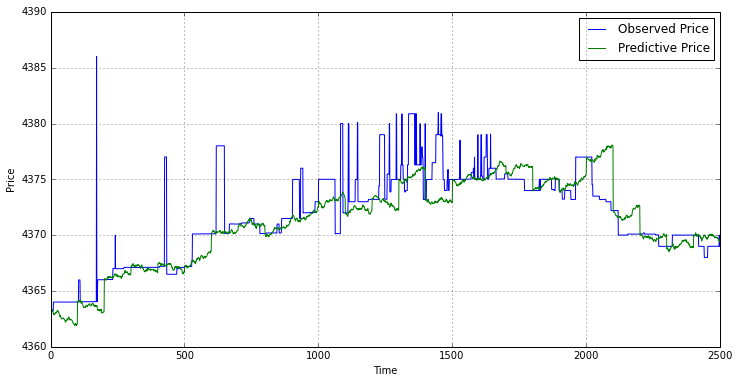

In [37]:
def prediction(thin, burnin, samples):
    m, v = samples[0,:], samples[1,:]
    m = m[0:len(m):thin][burnin:]
    v = v[0:len(v):thin][burnin:]
    
    ypred = np.random.normal(m, v)
    return np.mean(ypred)

N = 2500
predList = np.zeros(N)
priceList = bid['price'].tolist()
lastPrice = priceList[2499]
for i in np.arange(N):
    if i%100 == 0: result = gibbs(X_train[i:i+2500], N=5000, start = [0,1])
    ypred = prediction(2,1,result)
    predList[i] = np.exp(ypred)*lastPrice
    if i%100 == 0: lastPrice = priceList[2500+i]
    else: lastPrice = predList[i]
    
plt.figure(figsize = (12,6))
plt.plot(priceList[2500:(2500+N)], label = 'Observed Price')
plt.plot(predList, label = 'Predictive Price')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

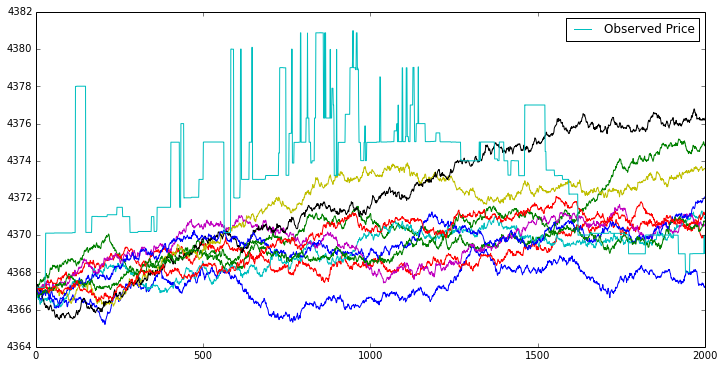

In [40]:
N = 2000
predList = np.zeros(N)
priceList = bid['price'].tolist()[1000:]

plt.figure(figsize = (12,6))
for j in np.arange(10):
    lastPrice = priceList[1999]
    for i in np.arange(N):
        ypred = prediction(2,1,result)
        predList[i] = np.exp(ypred)*lastPrice
        lastPrice = predList[i]
    plt.plot(predList)
plt.plot(priceList[2000:(2000+N)], label = 'Observed Price')
plt.legend()
plt.show()